<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/Infection_pulmonaire_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données**

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import tensorflow as tf
import keras
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
A = zip_ref.close()

# **I - Etude de la distribution des données "brutes"**

### I - 1. Code pour la visualisation générale du jeu de données

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualisation(infoGen, camembert, histogr, infoMoy):
  
  tab_normal = []
  tab_malade = []
  nb_img_total = 0
  nb_img_normal = 0
  nb_img_malade = 0
  path_normal = '/tmp/COVID_crop/normal'
  path_malade = '/tmp/COVID_crop/malade'

  for base in os.walk(path_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
    nb_img_total += len(base[2])
    nb_img_normal += len(base[2])
  tab_normal.pop(0)
  tab_normal.sort()
  #print(tab_normal)
  for base in os.walk(path_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
    nb_img_total += len(base[2])    
    nb_img_malade += len(base[2])
  tab_malade.pop(0)
  tab_malade.sort()
  #print(tab_malade)

  #---------- infos générales ----------
  if infoGen == True:
    print("\n---------- infos générales ----------\n")
    print('Nombre de scans cas "normale" :', len(os.listdir('/tmp/COVID_crop/normal')))
    print('Nombre de scans cas "malade" :', len(os.listdir('/tmp/COVID_crop/malade')))
    print('''\nNombre d'images cas "normal" :''', nb_img_normal)
    print('''Nombre d'images cas "malade" :''', nb_img_malade)
    print('''Nombre d'images total :''', nb_img_total)

  #---------- camembert ----------
  if camembert == True:
    x = np.array([len(os.listdir(path_normal)), len(os.listdir(path_malade))])
    labels = ['normal', 'malade']
    colors = {'normal': 'chartreuse','malade': 'teal' }
    plt.pie(x, labels=labels, autopct='%.0f%%', radius=0.8, colors=[colors[key] for key in labels], textprops={'fontsize': 18})
    plt.show()

  #---------- histogramme ----------
  if histogr == True:
    print("\n---------- histogramme ----------\n")
    plt.figure(figsize=(10, 10))
    x0 = tab_normal
    x1 = tab_malade
    plt.hist(x0, alpha=0.6, align="mid", label="Distribution du nombre d'images par scan normal")
    plt.hist(x1, alpha=0.6, align="mid", label="Distribution du nombre d'images par scan malade")
    plt.legend(loc='lower right')
    plt.xlabel("Nombres d'images par scan")
    plt.ylabel("Occurences")
    plt.show()

  #---------- infos sur les moyennes ----------
  if infoMoy == True:
    print("\n---------- infos sur les moyennes ----------\n")
    x0_mean = np.mean(tab_normal)
    x1_mean = np.mean(tab_malade)
    tot_mean = (nb_img_normal/nb_img_total)*x0_mean + (nb_img_malade/nb_img_total)*x1_mean
    print('''Moyenne d'images pour les scans cas "normal" :''', x0_mean)
    print('''Moyenne d'images pour les scans cas "malade" :''', x1_mean)
    print('''Moyenne d'images pour tous les scans confondus :''', tot_mean)

### I - 2. Analyse du jeu de données "brutes"


---------- infos générales ----------

Nombre de scans cas "normale" : 1078
Nombre de scans cas "malade" : 1544

Nombre d'images cas "normal" : 97695
Nombre d'images cas "malade" : 166484
Nombre d'images total : 264179


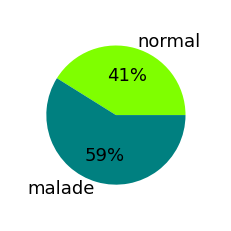


---------- histogramme ----------



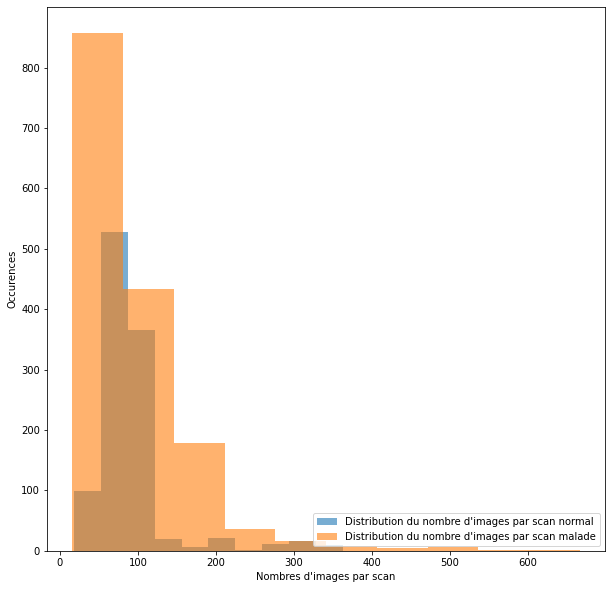


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 90.62615955473099
Moyenne d'images pour les scans cas "malade" : 107.82642487046633
Moyenne d'images pour tous les scans confondus : 101.46566220567934


In [48]:
visualisation(True, True, True, True)

Selon cette première visualisation du jeu de données "brutes", nous remarquons plusieurs points sur lequels nous pouvons travailler afin d'obtenir un jeu  plus lisible pour l'algorithme de deep learning que nous implémenterons par la suite. En effet, selon l'histogramme regroupant l'ensemble des scans de personnes malades et normales, nous pouvons observer : 

1. D'une part, une distribution du nombre d'images par scan assez étalée avec des cas extrêmes inexploitables à ignorer : ~10 ou +600 images par scan
2. D'autre part, une moyenne du nombre d'images par scan différente et non précise pour les deux cas :
  *   🤒 "malade" avec 2 pics d'occurences pour des scans contenant ~60 et ~140 images
  *   🙂 "normal" avec des pics aux alentours de 90 images par scan

Ainsi, nous allons réaliser dans ***II.Padding des données*** un nettoyage et une standardisation du jeu de données pour permettre d'une part un traitement plus aisé, et d'autre part de réduire le poids de stockage. Nous aimerions ainsi obtenir un nombre fixé d'images par scan quelque soit le cas, pour tous les scans du jeu de données.

# **II - Padding des données**

### II - 1. On élimine les scans contenant moins de 40 et plus de 100 images


In [49]:
import shutil
num_skipped = 0
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) >= 100 or len(os.listdir(fpath)) <= 40:
      num_skipped += 1
      shutil.rmtree(fpath)
print("Deleted %d scans" % num_skipped)

Deleted 1046 scans



---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 64146
Nombre d'images cas "malade" : 54849
Nombre d'images total : 118995

---------- histogramme ----------



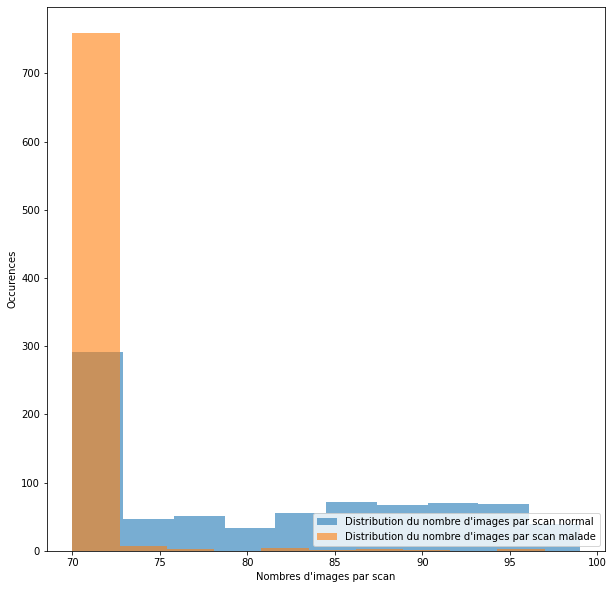


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 80.58542713567839
Moyenne d'images pour les scans cas "malade" : 70.31923076923077
Moyenne d'images pour tous les scans confondus : 75.85337449058166


In [50]:
visualisation(True, False, True, True)

### II - 2. On comble les scans contenant moins de 70 images (Choix à faire)

#### II - 2.1. Méthode 1 : Comble par ajout d'images noires 

In [51]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      for i in range (70 - len(os.listdir(fpath))) : 
        new_im = Image.new('RGB', (128, 128), (0, 0, 0))
        new_im.save(fpath + "/Dark_image" + str(i), "PNG")

In [52]:
visualisation(True, False, False, True)


---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 64146
Nombre d'images cas "malade" : 54849
Nombre d'images total : 118995

---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 80.58542713567839
Moyenne d'images pour les scans cas "malade" : 70.31923076923077
Moyenne d'images pour tous les scans confondus : 75.85337449058166


#### II - 2.2. Méthode 2 : Comble par copie d'images en partant du milieu du scan (bug)

In [39]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil
import os

def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      
      index_img1 = len(os.listdir(fpath))//2
      while os.path.exists(pathImg(index_img1)) == False:
        index_img1 += 1
      else:
        path_img1 = pathImg(index_img1)
        path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
        shutil.copy2(path_img1, path_img2)
        compteur_img_toAdd = 70 - len(os.listdir(fpath))
        #print(path_img2)
        #print(os.listdir(fpath))

        while compteur_img_toAdd != 0:
            
          index_img1 += 2
          path_img1 = pathImg(index_img1)
          path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
          shutil.copy2(path_img1, path_img2)
          compteur_img_toAdd -= 1

In [ ]:
visualisation(True, False, False, True)

### II - 3. On élimine des images dans les scans contenant plus de 70 images (Choix à faire)

#### II - 3.1. Méthode 1 : Elimination aléatoire

In [13]:
import shutil
import numpy as np

for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 70:
            while len(os.listdir(fpath)) !=70 :
                delete_path = fpath + "/00" + str(np.random.randint(10,len(os.listdir(fpath)))) + ".png"
                while os.path.exists(delete_path):  
                    os.remove(delete_path)

In [ ]:
visualisation(True, False, False, True)

#### II - 3.2. Méthode 2 : Elimination par comparaison SSIM

##### II - 3.2. Test & explications

SSIM(Score of similarity): 0.6683536764047817

Image 1 :



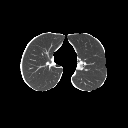


Image 2 :



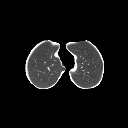


Différence :



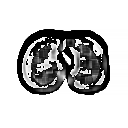

In [53]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image

path_image1 = "/tmp/COVID_crop/normal/1/0022.png"
path_image2 = "/tmp/COVID_crop/normal/1/0015.png"

# load the two input images
imageA = cv2.imread(path_image1)
imageB = cv2.imread(path_image2)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(imageA, imageB, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM(Score of similarity): {}".format(score))

from google.colab.patches import cv2_imshow
# show the output images
print("\nImage 1 :\n")
#img = load_img(path_image1, target_size=(48,48))   
#load_img.show()
cv2_imshow(imageA)
print("\nImage 2 :\n")
cv2_imshow(imageB)
print("\nDifférence :\n")
cv2_imshow(diff)

The ***score*** represents the structural similarity index between the two input images. This value can fall into the range [-1, 1] with a value of one being a “perfect match”.

The ***diff*** image contains the actual image differences between the two input images that we wish to visualize. The difference image is currently represented as a floating point data type in the range [0, 1] so we first convert the array to 8-bit unsigned integers in the range [0, 255] (Line 26) before we can further process it using OpenCV.

##### II - 3.2. Methode

In [54]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil
import numpy as np

def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) > 70:
      compteur_img_toDel = len(os.listdir(fpath)) - 70
      while compteur_img_toDel != 0:

        # ---------- choix des images à comparer ----------
        
        # choix index image1
        # sachant que les images sont numérotées entre 0001 et 0***
        # méthode : choix random de l'index
        
        index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        while os.path.exists(pathImg(index_img1)) == False:
          index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        else:
          path_img1 = pathImg(index_img1)

        # choix index image2
        # sachant qu'elle doit être la plus proche voisine de l'image1
        # méthode : recherche de l'index le plus proche supérieur
        
        index_img2 = index_img1 + 1                
        while os.path.exists(pathImg(index_img2)) == False:
          index_img2 += 1
        else:
          path_img2 = pathImg(index_img2)

        # ------------- comparaison des 2 images successives -------------
        
        image1 = cv2.imread(path_img1)
        image2 = cv2.imread(path_img2)
        #print("\nImage1\nPath : ", path_img1, "\nShape : ", image1.shape)
        #print("Image2\nPath : ", path_img2, "\nShape : ", image2.shape, "\n")
        (score, diff) = compare_ssim(image1, image2, full=True, multichannel=True)
        diff = (diff * 255).astype("uint8")
        #print(fpath, compteur_img_toDel, "SSIM: {}".format(score))

        # ---------- suppression de l'image1 ----------
        
        # critère : SSIM > 0.80 (images très similaires)
        if score > 0.80 and compteur_img_toDel != 0 :
          compteur_img_toDel -= 1
          while os.path.exists(path_img1):
            os.remove(path_img1)

In [55]:
visualisation(True, False, False, True)


---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 55720
Nombre d'images cas "malade" : 54600
Nombre d'images total : 110320

---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 70.0
Moyenne d'images pour les scans cas "malade" : 70.0
Moyenne d'images pour tous les scans confondus : 70.0


Attention méthode SSIM moyen car des images toutes noires sont plus similaires à d'autres "moyenne" que deux "moyennes" entre elles...

# **III - Conversion hdf5**



In [ ]:
import os
import h5py
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import PIL

arrlist_normal = []
folder_path = os.path.join("/tmp/COVID_crop", "normal")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath + "/" + imgs).resize((48, 48))) / 255
      arrlist_normal.append(array)          

arrlist_malade = []
folder_path = os.path.join("/tmp/COVID_crop", "malade")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath + "/" + imgs).resize((48, 48))) / 255
      arrlist_malade.append(array)  

In [ ]:
h5f = h5py.File('/content/drive/MyDrive/UV PROJET P6/Dataset_normal.hdf5', 'w')
h5f.create_dataset('dataset_1', data=arrlist_normal)
h5f.close()

In [ ]:
h5f1 = h5py.File('/content/drive/MyDrive/UV PROJET P6/Dataset_malade.hdf5', 'w')
h5f1.create_dataset('dataset_2', data=arrlist_malade)
h5f1.close()